# Практика 7: Создание и использование генеративных противоречивых примеров (GANbased Adversarial Examples)
# Чурсинов Герман ББМО-01-23

## Изучить использование генеративных моделей (GAN — Generative Adversarial Networks) для создания противоречивых примеров. В этом задании мы создадим противоречивые примеры с использованием GAN и проверим их влияние на модели классификации.

## Задачи:
1. Изучить концепцию генеративных противоречивых примеров.
2. Реализовать простую GAN для создания противоречивых изображений.
3. Оценить точность моделей классификации на противоречивых примерах, созданных с помощью GAN.
4. Сравнить атаку на обе модели (полносвязную и свёрточную сети).

## Шаги выполнения:
**Шаг 1: Концепция генеративных противоречивых примеров**

Генеративные противоречивые примеры — это изображения, созданные генеративными моделями, которые могут обманывать модели классификации. В отличие от стандартных атак (например, FGSM или PGD), где добавляются малые шумы, GAN могут генерировать реалистичные, но сложные для распознавания модели изображения, которые сложно отличить от настоящих данных.

**Шаг 2: Создание простой GAN для генерации противоречивых примеров**

Мы создадим генеративную состязательную сеть (GAN), состоящую из двух частей: генератора и дискриминатора. Генератор будет создавать изображения, а дискриминатор — пытаться распознать поддельные изображения.



In [9]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Поскольку в среде Google Colab ограниченное количество ОЗУ, которое выделяется в бесплатном тарифе, 10000 эпох для обучения GAN слишком много. Было принято решение взять 1000 эпох (в 10 раз меньше).

![](https://i.imgur.com/KX9OdJY.png)

![](https://i.imgur.com/7cJ5MV4.png)

![](https://i.imgur.com/1PQH0NR.png)

In [3]:
# Загрузка данных MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0
# Добавление одного измерения (для работы CNN)
train_images = np.expand_dims(train_images, axis=-1)
# Генератор
def build_generator():
 model = tf.keras.Sequential()
 model.add(layers.Dense(128, activation='relu', input_dim=100))
 model.add(layers.BatchNormalization())
 model.add(layers.LeakyReLU())
 model.add(layers.Dense(784, activation='tanh'))
 model.add(layers.Reshape((28, 28, 1)))
 return model

# Дискриминатор
def build_discriminator():
 model = tf.keras.Sequential()
 model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1)))
 model.add(layers.LeakyReLU())
 model.add(layers.MaxPooling2D(pool_size=(2, 2)))
 model.add(layers.Flatten())
 model.add(layers.Dense(1, activation='sigmoid'))
 return model

# Создание моделей
generator = build_generator()
discriminator = build_discriminator()
# Компиляция дискриминатора
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Создание GAN
gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False
validity = discriminator(generated_image)
gan = tf.keras.Model(gan_input, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Функция обучения GAN
def train_gan(generator, discriminator, gan, epochs=1000, batch_size=64):
  half_batch = batch_size // 2
  for epoch in range(epochs):
    # Обучение дискриминатора
    idx = np.random.randint(0, train_images.shape[0], half_batch)
    real_images = train_images[idx]
    noise = np.random.normal(0, 1, (half_batch, 100))
    fake_images = generator.predict(noise)
    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

    # Обучение генератора через дискриминатор
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_labels)
    if epoch % 100 == 0:
      print(f'{epoch} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]')

# Обучение GAN
train_gan(generator, discriminator, gan)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: [0.71400476 0.28125   ]] [G loss: [array(0.70477545, dtype=float32), array(0.70477545, dtype=float32), array(0.4375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

**Шаг 3: Генерация противоречивых примеров с помощью GAN**

Теперь мы сгенерируем противоречивые примеры, используя обученный генератор GAN.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


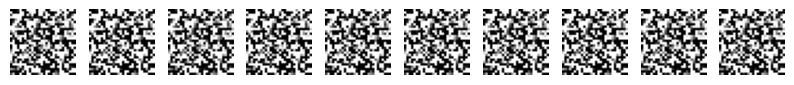

In [4]:
# Генерация противоречивых примеров
def generate_adversarial_examples(generator, n_samples):
 noise = np.random.normal(0, 1, (n_samples, 100))
 generated_images = generator.predict(noise)
 return generated_images
# Генерация 100 примеров
adversarial_images = generate_adversarial_examples(generator, 100)
# Визуализация противоречивых примеров
plt.figure(figsize=(10, 10))
for i in range(10):
 plt.subplot(1, 10, i+1)
 plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
 plt.axis('off')
plt.show()

**Шаг 4: Оценка моделей на противоречивых примерах**

Теперь проверим, как обученные модели (полносвязная сеть и CNN) справляются с противоречивыми примерами, созданными с помощью GAN.

In [6]:
# Скачаем 2 модели из шестой практики
!wget https://github.com/l-Il/AZSII/raw/refs/heads/main/prz_6/mnist_model1.h5
!wget https://github.com/l-Il/AZSII/raw/refs/heads/main/prz_6/mnist_model2.h5

--2024-12-12 20:13:06--  https://github.com/l-Il/AZSII/raw/refs/heads/main/prz_6/mnist_model1.h5
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/l-Il/AZSII/refs/heads/main/prz_6/mnist_model1.h5 [following]
--2024-12-12 20:13:06--  https://raw.githubusercontent.com/l-Il/AZSII/refs/heads/main/prz_6/mnist_model1.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1244464 (1.2M) [application/octet-stream]
Saving to: ‘mnist_model1.h5’

mnist_model1.h5     100%[===================>]   1.19M  --.-KB/s    in 0.05s   

2024-12-12 20:13:07 (24.3 MB/s) - ‘mnist_model1.h5’ saved [1244464/1244464]

--2024-12-

In [7]:
# Загрузка обученных моделей
model1 = tf.keras.models.load_model('mnist_model1.h5')
model2 = tf.keras.models.load_model('mnist_model2.h5')
# Оценка первой модели на противоречивых примерах
adv_images_reshaped = adversarial_images.reshape(-1, 28, 28, 1)
loss1, acc1 = model1.evaluate(adv_images_reshaped, np.ones((100, 10))) # Примерные метки
print(f'Accuracy of model1 on adversarial GAN examples: {acc1}')
# Оценка второй модели на противоречивых примерах
loss2, acc2 = model2.evaluate(adv_images_reshaped, np.ones((100, 10))) # Примерные метки
print(f'Accuracy of model2 on adversarial GAN examples: {acc2}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 171.8183  
Accuracy of model1 on adversarial GAN examples: 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 570.8055  
Accuracy of model2 on adversarial GAN examples: 0.0


Шаг 5: Анализ результатов

Проанализируйте результаты. Ожидается, что обе модели покажут низкую точность на противоречивых примерах, созданных генератором GAN. Дополнительное задание (усложнение)

In [12]:
adv_images_reshaped = adversarial_images.reshape(-1, 28, 28, 1)

# Создание примерных меток
adversarial_labels = np.random.randint(0, 10, size=(len(adversarial_images),))
adversarial_labels_one_hot = tf.keras.utils.to_categorical(adversarial_labels, num_classes=10)

# Предсказания и оценка первой модели
predictions1 = model1.predict(adv_images_reshaped)
y_pred1 = np.argmax(predictions1, axis=1)
report1 = classification_report(adversarial_labels, y_pred1, digits=4)
print("Classification Report for Model1:\n", report1)

# Предсказания и оценка второй модели
predictions2 = model2.predict(adv_images_reshaped)
y_pred2 = np.argmax(predictions2, axis=1)
report2 = classification_report(adversarial_labels, y_pred2, digits=4)
print("Classification Report for Model2:\n", report2)

# Сравнение по метрикам
print("Summary of Model Performance:")
print("Model1 Performance:\n", report1)
print("Model2 Performance:\n", report2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report for Model1:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        10
           1     0.0000    0.0000    0.0000         8
           2     0.0000    0.0000    0.0000         7
           3     0.0000    0.0000    0.0000        13
           4     0.0000    0.0000    0.0000        11
           5     0.1200    1.0000    0.2143        12
           6     0.0000    0.0000    0.0000         6
           7     0.0000    0.0000    0.0000        10
           8     0.0000    0.0000    0.0000        11
           9     0.0000    0.0000    0.0000        12

    accuracy                         0.1200       100
   macro avg     0.0120    0.1000    0.0214       100
weighted avg     0.0144    0.1200    0.0257       100

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Classification Report for Model2:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

# **Результаты:**

Мы научились использовать GAN для генерации противоречивых примеров, а также поняли, как такие примеры могут вводить модели в заблуждение, даже если они выглядят как реальные данные. Также мы оценили влияние противоречивых примеров на различные архитектуры моделей.
Мы проанализировали переносимость противоречивых примеров и их влияние на модели с помощью `classification_report` из библиотеки sklearn, помимо стандартного сравнения значений accuracy.

P.S. В GitHub не вижу смысла загружать (дублировать) модели `mnist_model1.h5` и `mnist_model2.h5`, поскольку они были загружены из шестой практики с помощью фрагмента кода.